# Восстановление золота
Проект предоставлен компанией ["Цифра"](https://www.zyfra.com/)
#### Цель:  
Подготовка прототипа модели машинного обучения для увеличения эффективности работы промышленного предприятия.
#### Задача:  
Модель должна предсказывать коэффициент восстановления золота из золотосодержащей руды лучше константной модели.  


#### Описание данных  
**Технологический процесс**   
Rougher feed — исходное сырье  
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
Xanthate — ксантогенат (промотер, или активатор флотации);  
Sulphate — сульфат (на данном производстве сульфид натрия);  
Depressant — депрессант (силикат натрия).  
Rougher process — флотация  
Rougher tails — отвальные хвосты  
Float banks — флотационная установка  
Cleaner process — очистка  
Rougher Au — черновой концентрат золота  
Final Au — финальный концентрат золота  
  
**Параметры этапов**   
air amount — объём воздуха  
fluid levels — уровень жидкости  
feed size — размер гранул сырья  
feed rate — скорость подачи  
  
**Наименование признаков**  
Наименование признаков такое:  
[этап].[тип_параметра].[название_параметра]  
Пример: rougher.input.feed_ag  
Возможные значения для блока [этап]:  
rougher — флотация  
primary_cleaner — первичная очистка  
secondary_cleaner — вторичная очистка  
final — финальные характеристики  
Возможные значения для блока [тип_параметра]:  
input — параметры сырья  
output — параметры продукта  
state — параметры, характеризующие текущее состояние этапа  
calculation — расчётные характеристики  

# 1. Подготовка данных

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

Открываем данные

In [48]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [49]:
gold_recovery_train.info()
gold_recovery_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [50]:
gold_recovery_test.info()
gold_recovery_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [51]:
gold_recovery_full.info()
gold_recovery_full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


#### Проверим, правильно ли рассчитана эффективность обогащения.  
Для этого вычислим её на обучающей выборке для признаков **rougher.output.recovery** и **final.output.recovery** и найдем MAE (среднее обсалютное отклонение) между расчётами и значениями признаков.

C — доля золота в концентрате после флотации/очистки - соответственно, **rougher.output.concentrate_au** и **final.output.concentrate_au**    
F — доля золота в сырье/концентрате до флотации/очистки - соответственно, **rougher.input.feed_au** и **rougher.output.concentrate_au**  
T — доля золота в отвальных хвостах после флотации/очистки - соответственно, **rougher.output.tail_au** и **final.output.tail_au**  

In [52]:
# определим фугкцию для расчета MAE
def recovery_MAE (data, c, f, t, target):
    # так как данные ещё не предобработаны, 
    # то возьмем только те значения, которые присутствуют во всех признаках
    only_positive = ((data[c] > 0) 
                   & (data[f] > 0) 
                   & (data[t] > 0) 
                   & (data[target] > 0))
    C = data[only_positive][c]
    F = data[only_positive][f]
    T = data[only_positive][t]
    recovery = C * (F - T) / (F * (C - T)) * 100
    print('Строк, участвующих в расчете:', len(recovery))
    print('MAE =', mean_absolute_error(data[only_positive][target], recovery))

Посчитаем MAE в случает только флотации

In [53]:
recovery_MAE (gold_recovery_train, 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery')

Строк, участвующих в расчете: 13967
MAE = 9.661285240080234e-15


Посчитаем MAE в случае полного процесса

In [54]:
recovery_MAE (gold_recovery_train, 'final.output.concentrate_au', 'rougher.input.feed_au', 'final.output.tail_au', 'final.output.recovery')

Строк, участвующих в расчете: 14779
MAE = 8.46738118944879e-15


В обоих случаях MAE = 0, следовательно, эффективность обогащения рассчитывается правильно, но с использованием данных, которые приходят потом. Надо научится предсказывать эффетивность до начала процесса обогащения. Поэтому в тестовой выборке, в отличии от тренировочной, нет следующих признаков:

In [55]:
gold_recovery_train.drop(gold_recovery_test.columns, axis = 1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.output.concentrate_ag                 16778 non-null float64
primary_cleaner.output.concentrate_pb                 16502 non-null float64
primary_cleaner.output.concentrate_sol      

То есть в тестовой выборке нет параметров продукта (**output**) и расчётных характеристик (**calculation**), а также целевых признаков **rougher.output.recovery**, **final.output.recovery**

### Предобработка

Поменяем во всех выборках индексы на столбец **date**, чтобы у выборок была единая индексация

In [56]:
gold_recovery_train.index = gold_recovery_train['date']
gold_recovery_test.index = gold_recovery_test['date']
gold_recovery_full.index = gold_recovery_full['date']

Посмотрим, сколько строк останется, если удалить все строки с пустыми значениями:

In [57]:
print('Размер обучающей выборки:', gold_recovery_train.shape)
print('Размер обучающей выборки, если удалить строки с пустыми значениями:', gold_recovery_train.dropna().shape)

Размер обучающей выборки: (16860, 87)
Размер обучающей выборки, если удалить строки с пустыми значениями: (11017, 87)


In [58]:
print('Размер тестовой выборки:', gold_recovery_test.shape)
print('Размер тестовой выборки, если удалить строки с пустыми значениями:', gold_recovery_test.dropna().shape)

Размер тестовой выборки: (5856, 53)
Размер тестовой выборки, если удалить строки с пустыми значениями: (5383, 53)


Из обучающе выборки удалится 25%, а из тестовой 11%, поэтому пропуски стоит попробовать заполнить.  
Так как соседние по времени параметры часто похожи, то попробуем заполнить пропущенное значение предыдущим непропущенным:

In [59]:
df = gold_recovery_train.fillna(method = 'ffill')

In [60]:
recovery_MAE (df, 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery')

Строк, участвующих в расчете: 15225
MAE = 60.66821979830774


In [61]:
print('Среднее значение эффективности обогащения', gold_recovery_train['rougher.output.recovery'].mean())

Среднее значение эффективности обогащения 82.39420120842001


MAE составило почти 70% от среднего значения эффективности обогащения (60 от 82). Так как до заполнения MAE = 0, то такое заполнение не подходит.

Попытаемся выяснить в чем причина такого плохого заполнения.  
Рассмотрим признаки, используемые для расчета МАЕ, в случае, когда поступающее сырье = 0

In [62]:
(gold_recovery_train[gold_recovery_train['rougher.input.feed_au'] == 0]
 [['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']].head())

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery
date,,,,
2016-01-19 03:00:00,0.0,0.0,NaN,NaN
2016-01-19 04:00:00,0.0,0.0,NaN,NaN
2016-01-19 05:00:00,0.0,0.0,NaN,NaN
2016-01-19 06:00:00,0.0,0.0,NaN,NaN
2016-01-19 07:00:00,0.0,0.0,NaN,NaN


Посмотрим, что было за час до этого

In [63]:
(gold_recovery_train[gold_recovery_train.index == '2016-01-19 02:00:00']
 [['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']].head())

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery
date,,,,
2016-01-19 02:00:00,7.624713,3.3311,2.774298,26.275908


Получается, что заполнение пропусков предыдущими значениями не подходит, потому что пропуски идут группой, а не по одному, и другие признаки при этом могут зануляться.  
Поэтому придется просто удалить строки с пропусками

Добавим к тестовой выборке целевые признаки **rougher.output.recovery** и **final.output.recovery**

In [64]:
gold_recovery_test[['rougher.output.recovery', 'final.output.recovery']] = gold_recovery_full[['rougher.output.recovery', 'final.output.recovery']]

Оставим в выборке **gold_recovery_train** только те признаки, которые есть в **gold_recovery_test**:

In [65]:
gold_recovery_train = pd.DataFrame(data = gold_recovery_train, columns = gold_recovery_test.columns)

Удалим все строки с пустыми значениями

In [66]:
gold_recovery_train = gold_recovery_train.dropna()

In [67]:
gold_recovery_test = gold_recovery_test.dropna()

### Вывод

Так как пропуски не удалось заполнить, то пришлос их удалить.

## 2. Анализ данных

#### Рассмотрим концентрацию металлов на разных стадиях очистки

In [68]:
print('Медиана концентрации серебра на разных стадиях очистки:')
for data in ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']:
    print(gold_recovery_full[data].median())

Медиана концентрации серебра на разных стадиях очистки:
11.785126843749236
8.26564348298084
4.9537289473495845


In [69]:
print('Медиана концентрации свинца на разных стадиях очистки:')
for data in ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']:
    print(gold_recovery_full[data].median())

Медиана концентрации свинца на разных стадиях очистки:
7.572854680346531
9.921116466257306
9.914518724547492


In [70]:
print('Медиана концентрации золота на разных стадиях очистки:')
for data in ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']:
    print(gold_recovery_full[data].median())

Медиана концентрации золота на разных стадиях очистки:
20.003201585148012
32.359813117181226
44.65343597067188


Видно, что концентрация серебра к концу оцистки падает, свинца - изменяется незначительно, золота - растет

#### Рассмотрим распределения размеров гранул сырья на обучающей и тестовой выборках

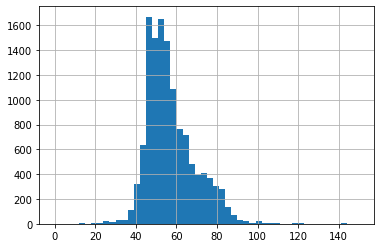

In [71]:
gold_recovery_train['rougher.input.feed_size'].hist(bins = 50, range = (0, 150))

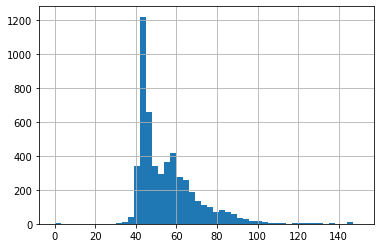

In [72]:
gold_recovery_test['rougher.input.feed_size'].hist(bins = 50, range = (0, 150))

На гистограммах наблюдаются различия распределений тренировочной и тестовой выборки: само по себе распределение тестовой выборки уже, но максимум находится примерно на том же месте.

#### Исследуем суммарную концентрацию всех веществ на разных стадиях очистки

In [73]:
def make_hist(name):
    (gold_recovery_full[name + 'ag'] + 
     gold_recovery_full[name + 'pb'] + 
     gold_recovery_full[name + 'au'] + 
     gold_recovery_full[name + 'sol']).hist(bins = 50);

Гистограмма веществ исходного сырья


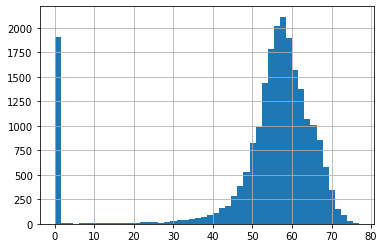

In [74]:
print('Гистограмма веществ исходного сырья')
make_hist('rougher.input.feed_')

Гистограмма суммарной концентрации веществ после черновой очистки


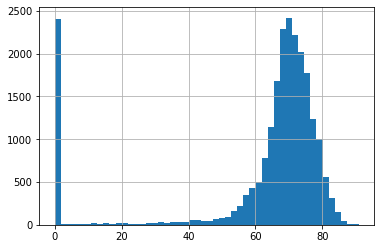

In [75]:
print('Гистограмма суммарной концентрации веществ после черновой очистки')
make_hist('rougher.output.concentrate_')

Гистограмма суммарной концентрации веществ после первой очистки


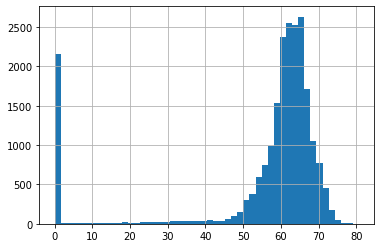

In [76]:
print('Гистограмма суммарной концентрации веществ после первой очистки')
make_hist('primary_cleaner.output.concentrate_')

Гистограмма окончательной суммарной концентрации веществ


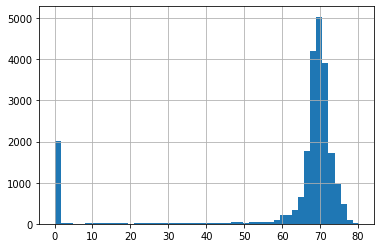

In [77]:
print('Гистограмма окончательной суммарной концентрации веществ')
make_hist('final.output.concentrate_')

Во всех случаях наблюдаются большие выбросы в нуле и около его, которые надо убрать.

Посмотрим размер выборок до удаление выбросов

In [78]:
print('Размер тренировочной выборки:', gold_recovery_train.shape)
print('Размер тренировочной выборки:', gold_recovery_test.shape)

Размер тренировочной выборки: (12679, 55)
Размер тренировочной выборки: (5229, 55)


Убираем нулевые значения, а также те строчки, где суммарная концентрация меньше 15.

In [79]:
for name in ['final.output.concentrate_', 'primary_cleaner.output.concentrate_', 'rougher.output.concentrate_', 'rougher.input.feed_']:
    for metal in ['ag', 'pb', 'au', 'sol']:
        gold_recovery_train[name + metal] = gold_recovery_full[name + metal]
        gold_recovery_test[name + metal] = gold_recovery_full[name + metal]
    cut_for = (gold_recovery_train[name + 'ag'] + gold_recovery_train[name + 'pb'] +gold_recovery_train[name + 'au'] +gold_recovery_train[name + 'sol'])   
    gold_recovery_train = gold_recovery_train[cut_for > 15]
    cut_for = (gold_recovery_test[name + 'ag'] + gold_recovery_test[name + 'pb'] +gold_recovery_test[name + 'au'] +gold_recovery_test[name + 'sol'])   
    gold_recovery_test = gold_recovery_test[cut_for > 15]    

In [80]:
for name in ['final.output.concentrate_', 'primary_cleaner.output.concentrate_', 'rougher.output.concentrate_']:
    for metal in ['ag', 'pb', 'au', 'sol']:    
        gold_recovery_train.drop(name + metal, axis = 1, inplace = True)
        gold_recovery_test.drop(name + metal, axis = 1, inplace = True)

Посмотрим размер выборок после удаление нулевых значений

In [81]:
print('Размер тренировочной выборки:', gold_recovery_train.shape)
print('Размер тренировочной выборки:', gold_recovery_test.shape)

Размер тренировочной выборки: (11894, 55)
Размер тренировочной выборки: (4997, 55)


Обе выборки уменьшились примерно на 5%, что является приемлемым результатом.

Возвращаем индексам обычный вид и убираем столбец **date** из выборок

In [82]:
gold_recovery_train.reset_index(drop = True, inplace = True)
gold_recovery_train.drop('date', axis = 1, inplace = True)
gold_recovery_test.reset_index(drop = True, inplace = True)
gold_recovery_test.drop('date', axis = 1, inplace = True)

### Вывод

* Концентрация залота в процессе очистки растет, серебра - падает, свинца - изменяется не значительно  
* Размер гранул сырья на тестовой и обучающих выборках отличается, но не сильно  
* Выбросы из тренировочной и тестовой выборок удалены

# 3. Модель

#### Определим функцию для вычисления итогового sMAPE

In [83]:
def final_sMAPE(target, prediction):
    tar = np.array(target, float)
    pred = np.array(prediction, float)
    roug = ((2 * abs(tar[:,0] - pred[:,0]) / (abs(tar[:,0]) + abs(pred[:,0]))).sum() / len(tar) * 100)
    fin = ((2 * abs(tar[:,1] - pred[:,1]) / (abs(tar[:,1]) + abs(pred[:,1]))).sum() / len(tar) * 100)
    return 0.25 * float(roug) + 0.75 * float(fin)

In [84]:
from IPython.display import display
arr = np.random.rand(5,5)
display(arr)
display(arr[0]) #Первая строка
display(arr[:,0]) #Первая колонка

array([[0.07911113, 0.41575076, 0.25939174, 0.00976721, 0.79587264],
       [0.66457903, 0.62375184, 0.43073041, 0.99558938, 0.65449601],
       [0.45156467, 0.85899995, 0.89080192, 0.99510206, 0.28045255],
       [0.51481736, 0.18410441, 0.97631461, 0.72871568, 0.23202269],
       [0.05831306, 0.85675588, 0.74225903, 0.49726047, 0.34263044]])

array([0.07911113, 0.41575076, 0.25939174, 0.00976721, 0.79587264])

array([0.07911113, 0.66457903, 0.45156467, 0.51481736, 0.05831306])

In [85]:
my_scorer = make_scorer(final_sMAPE, greater_is_better=False)

#### Оценка качества моделей кросс-валидацией

Разделяем в тренировочной выборке признаки и ключевые признаки

In [86]:
features_train = gold_recovery_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train = gold_recovery_train[['rougher.output.recovery', 'final.output.recovery']]

Отмасштабируем признаки

In [87]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train[features_train.columns])

#### Рассмотри модель линейной регрессии

In [88]:
model_LR = LinearRegression()
print('Итоговое sMAPE:', abs(cross_val_score(model_LR, features_train, target_train, scoring = my_scorer, cv=3).mean()))

Итоговое sMAPE: 10.570530147980902


Итоговое sMAPE составило 10,57%

#### Рассмотрим модель случайного леса

Подберем сначала гиперпараметры **n_estimators** и **max_depth**

In [1157]:
%%time
f_sMAPE = -1000
n_estimators = 0
max_depth = 0
for i in range(90, 111, 10):
    for j in range (20, 31, 5):
        model_forest = RandomForestRegressor(n_estimators=i, max_depth=j, random_state=12345)
        sMAPE = cross_val_score(model_forest, features_train, target_train, scoring = my_scorer, cv=3).mean()
        if sMAPE > f_sMAPE:
            f_sMAPE = sMAPE
            n_estimators = i
            max_depth = j
print('Итоговое sMAPE:', abs(f_sMAPE), '\nn_estimators:', n_estimators, '\nmax_depth:', max_depth)

Итоговое sMAPE: 8.993957448090613 
n_estimators: 90 
max_depth: 20
CPU times: user 17min 9s, sys: 316 ms, total: 17min 9s
Wall time: 17min 20s


In [1158]:
features_train.shape

(11894, 52)

Теперь подберем гиперпараметры **max_features** и **min_samples_split**

In [1159]:
%%time
max_features = 40
min_samples_split=2
for i in range(40, 51, 5):
    for j in range (2, 7, 2):
            model_forest = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features = i, min_samples_split=j, random_state=12345)
            sMAPE = cross_val_score(model_forest, features_train, target_train, scoring = my_scorer, cv=3).mean()
            if sMAPE > f_sMAPE:
                f_sMAPE = sMAPE
                max_features = i
                min_samples_split = j
print('Итоговое sMAPE:', abs(f_sMAPE), '\nmax_features:', max_features, '\nmin_samples_split', min_samples_split)

Итоговое sMAPE: 8.788338767258432 
max_features: 40 
min_samples_split 6
CPU times: user 12min 43s, sys: 148 ms, total: 12min 43s
Wall time: 13min


Итоговое sMAPE составило 8,79%, что лучше, чем в модели линейной регрессии, поэтому для тестовой выборки будем использовать модель случайного леса с гиперпараметрами **n_estimators** = 90, **max_depth** = 20, **max_features** = 40 и **min_samples_split** = 6.

#### Проверка на тестоой выборке

Разделяем в тестовой выборке признаки и ключевые признаки

In [1160]:
features_train_test = gold_recovery_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_test = gold_recovery_test[['rougher.output.recovery', 'final.output.recovery']]
features_train_test = scaler.transform(features_train_test[features_train_test.columns])

Обучаем модель случайного леса на всей тренировочной выборке и проверяем на тестовой

In [1161]:
model_forest = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features = max_features, min_samples_split=min_samples_split, random_state=12345)

In [1162]:
%%time
model_forest.fit(features_train, target_train)
prediction_test = model_forest.predict(features_train_test)
print('Итоговое sMAPE на тестовой выборке:', final_sMAPE(target_train_test, prediction_test))

Итоговое sMAPE на тестовой выборке: 6.951135825376497
CPU times: user 38.4 s, sys: 0 ns, total: 38.4 s
Wall time: 39.5 s


Создаем вектор для проверки на константной модели, который состоит из средних значений ключевый признаков тренировочной выборки

In [89]:
const_check = np.full((len(gold_recovery_test), 2), [gold_recovery_train['rougher.output.recovery'].mean(), gold_recovery_train['final.output.recovery'].mean()])

In [90]:
print('Итоговое sMAPE, если вместо предказанных значений использовать среднее значение целевого признака:', final_sMAPE(target_train_test, const_check))

Итоговое sMAPE, если вместо предказанных значений использовать среднее значение целевого признака: 7.281353282869153


Итоговое sMAPE на тестовой выборке составило 6.95%, что на 0.3% лучше, чем на константой моделе.

# Вывод

* Выборки были очищены от пропусков и выбросов.  
* Распределения размеров гранул сырья на обучающей и тестовой выборках различаются не сильно.
* Итоговое sMAPE на тестовой выборке составило 6.95%, что лучше константной модели на 0.3%.